In [1]:
%%capture
!pip install dcurves==1.0.6.5

In [2]:
import dcurves
print(dcurves.__version__)

1.0.6.4


In [3]:
help(dcurves.plot_graphs)

Help on function plot_graphs in module dcurves.plot_graphs:

plot_graphs(plot_df: pandas.core.frame.DataFrame, graph_type: str = 'net_benefit', y_limits: Iterable = (-0.05, 1), color_names: Optional[Iterable] = None, show_grid: bool = True, show_legend: bool = True, smooth_frac: float = 0.0) -> None
    Plot specified graph type for the given data, either net benefit or net interventions avoided,
    against threshold probabilities. Applies LOWESS smoothing if `smooth_frac` is greater than 0,
    excluding 'all' and 'none' models from smoothing. The smoothing will be more sensitive to local variations,
    keeping the smoothed lines closer to the original data points if `smooth_frac` is specified.
    
    Parameters
    ----------
    plot_df : pd.DataFrame
        DataFrame containing 'threshold', 'model', and either 'net_benefit' or 'net_intervention_avoided' columns.
    graph_type : str, optional
        Specifies the type of plot to generate. Valid options are 'net_benefit' or 'n

In [4]:
%%capture
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
import statsmodels.api as sm
from dcurves import dca, plot_graphs
# Display plots in notebook
%matplotlib inline 

random.seed(112358)

df_cancer_dx = \
    pd.read_csv(
        "https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv"
    )

# Define the formula (make sure the column names in your DataFrame match these)
formula = 'cancer ~ marker + age + famhistory'

# Create cross-validation object
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=112358)

# Placeholder for predictions
cv_predictions = []

# Perform cross-validation
for train_index, test_index in rkf.split(df_cancer_dx):
    # Split data into training and test sets
    train, test = df_cancer_dx.iloc[train_index], df_cancer_dx.iloc[test_index]

    # Fit the model
    model = sm.Logit.from_formula(formula, data=train).fit(disp=0)

    # Make predictions on the test set
    test['cv_prediction'] = model.predict(test)

    # Store predictions
    cv_predictions.append(test[['patientid', 'cv_prediction']])

# Concatenate predictions from all folds
df_predictions = pd.concat(cv_predictions)

# Calculate mean prediction per patient
df_mean_predictions = df_predictions.groupby('patientid')['cv_prediction'].mean().reset_index()

# Join with original data
df_cv_pred = pd.merge(df_cancer_dx, df_mean_predictions, on='patientid', how='left')

# Decision curve analysis
# Generate net benefit score for each threshold value
df_dca_cv = dcurves.dca(
        data=df_cv_pred, modelnames=['cv_prediction'], outcome='cancer'
    )

In [5]:
df_dca_cv

,model,threshold,n,prevalence,harm,test_pos_rate,tp_rate,fp_rate,net_benefit,net_intervention_avoided
0,cv_prediction,0.00,750,0.14,0.0,1.000000,0.140000,0.860000,0.140000,NaN
1,cv_prediction,0.01,750,0.14,0.0,0.889333,0.138667,0.750667,0.131084,-0.022667
2,cv_prediction,0.02,750,0.14,0.0,0.756000,0.138667,0.617333,0.126068,0.177333
3,cv_prediction,0.03,750,0.14,0.0,0.662667,0.134667,0.528000,0.118337,0.159556
4,cv_prediction,0.04,750,0.14,0.0,0.612000,0.129333,0.482667,0.109222,0.121333
...,...,...,...,...,...,...,...,...,...,...
295,none,0.95,750,0.14,0.0,0.000000,0.000000,0.000000,0.000000,0.852632
296,none,0.96,750,0.14,0.0,0.000000,0.000000,0.000000,0.000000,0.854167
297,none,0.97,750,0.14,0.0,0.000000,0.000000,0.000000,0.000000,0.855670
298,none,0.98,750,0.14,0.0,0.000000,0.000000,0.000000,0.000000,0.857143


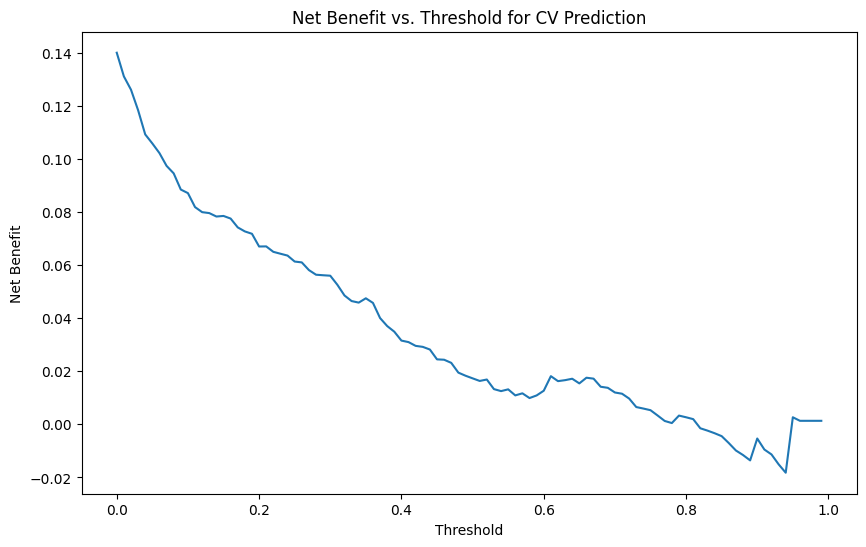

In [6]:
import matplotlib.pyplot as plt

# Filter the dataframe for rows where 'model' is 'cv_prediction'
filtered_df = df_dca_cv[df_dca_cv['model'] == 'cv_prediction']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['threshold'], filtered_df['net_benefit'])
plt.title('Net Benefit vs. Threshold for CV Prediction')
plt.xlabel('Threshold')
plt.ylabel('Net Benefit')
plt.grid(False)
plt.show()


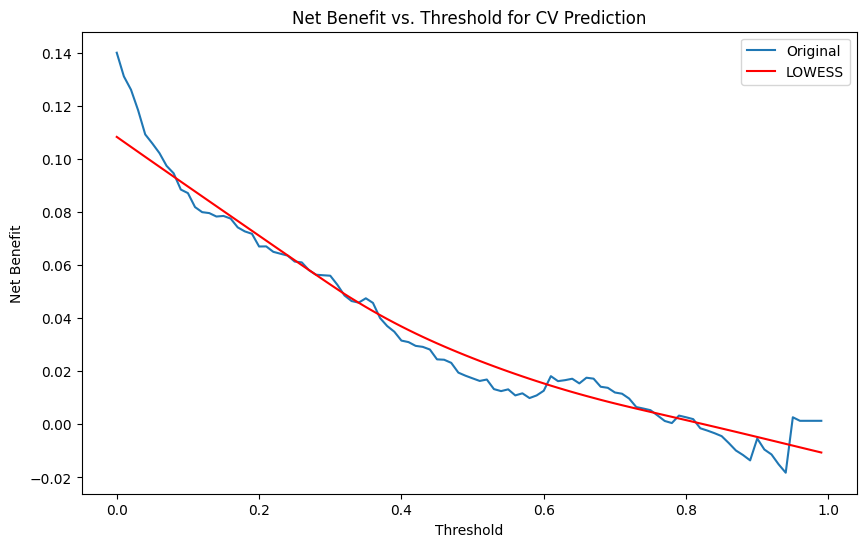

In [7]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Filter the dataframe for rows where 'model' is 'cv_prediction'
filtered_df = df_dca_cv[df_dca_cv['model'] == 'cv_prediction']

# LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(filtered_df['net_benefit'], filtered_df['threshold'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['threshold'], filtered_df['net_benefit'], label='Original')
plt.plot(smoothed[:, 0], smoothed[:, 1], label='LOWESS', color='red')  # Plot the smoothed curve
plt.title('Net Benefit vs. Threshold for CV Prediction')
plt.xlabel('Threshold')
plt.ylabel('Net Benefit')
plt.legend()
plt.grid(False)
plt.show()


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)


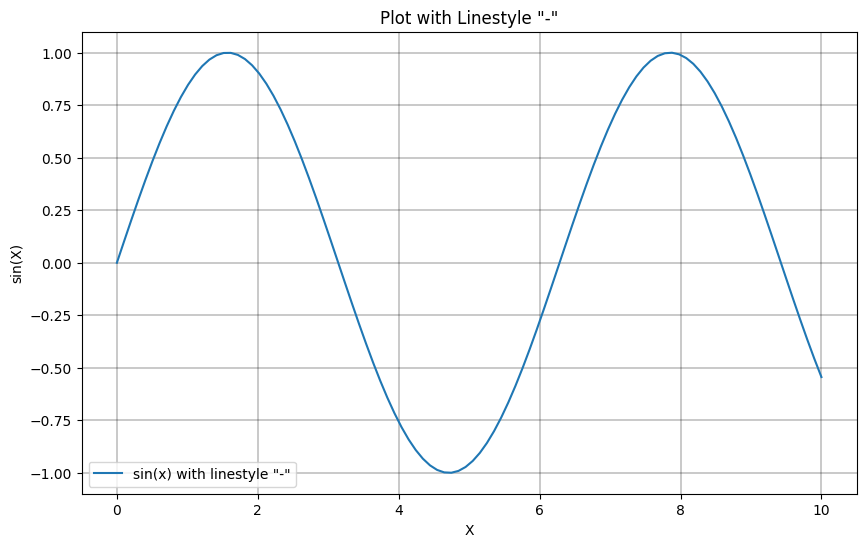

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, linestyle='-', label='sin(x) with linestyle "-"')
plt.title('Plot with Linestyle "-"')
plt.xlabel('X')
plt.ylabel('sin(X)')
plt.legend()
plt.grid(color="black", which="both", axis="both", linestyle='-', linewidth="0.3")
plt.show()


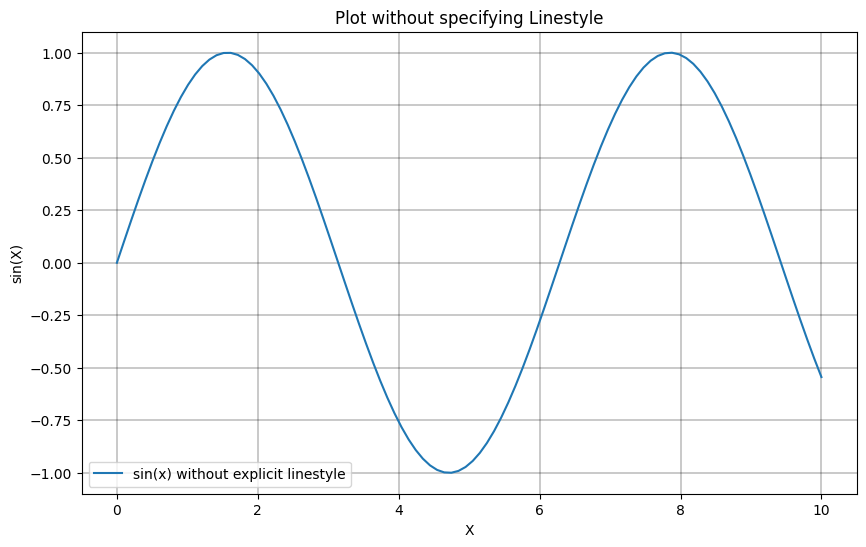

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='sin(x) without explicit linestyle')
plt.title('Plot without specifying Linestyle')
plt.xlabel('X')
plt.ylabel('sin(X)')
plt.legend()
plt.grid(color="black", which="both", axis="both", linewidth="0.3")
plt.show()


In [11]:
df_bin_dca = dcurves.dca(data=dcurves.load_test_data.load_binary_df(),
           outcome='cancer',
           modelnames=['famhistory', 'cancerpredmarker'])

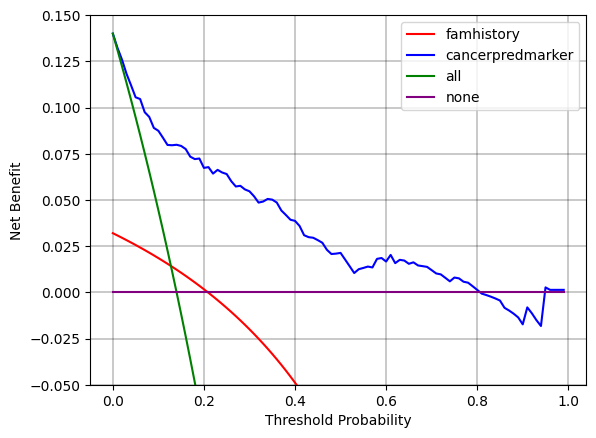

In [27]:
plot_graphs(plot_df=df_bin_dca, graph_type='net_benefit', color_names=['red', 'blue', 'green', 'purple'], y_limits=[-0.05,0.15])

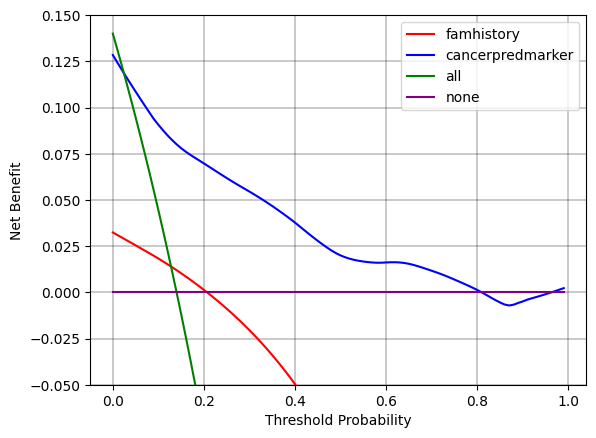

In [30]:
plot_graphs(plot_df=df_bin_dca, graph_type='net_benefit', color_names=['red', 'blue', 'green', 'purple'], y_limits=[-0.05,0.15], smooth_frac=0.2)

In [14]:
help(plot_graphs)

Help on function plot_graphs in module dcurves.plot_graphs:

plot_graphs(plot_df: pandas.core.frame.DataFrame, graph_type: str = 'net_benefit', y_limits: Iterable = (-0.05, 1), color_names: Optional[Iterable] = None, show_grid: bool = True, show_legend: bool = True, smooth_frac: float = 0.0) -> None
    Plot specified graph type for the given data, either net benefit or net interventions avoided,
    against threshold probabilities. Applies LOWESS smoothing if `smooth_frac` is greater than 0,
    excluding 'all' and 'none' models from smoothing. The smoothing will be more sensitive to local variations,
    keeping the smoothed lines closer to the original data points if `smooth_frac` is specified.
    
    Parameters
    ----------
    plot_df : pd.DataFrame
        DataFrame containing 'threshold', 'model', and either 'net_benefit' or 'net_intervention_avoided' columns.
    graph_type : str, optional
        Specifies the type of plot to generate. Valid options are 'net_benefit' or 'n

In [15]:
help(plot_graphs)

Help on function plot_graphs in module dcurves.plot_graphs:

plot_graphs(plot_df: pandas.core.frame.DataFrame, graph_type: str = 'net_benefit', y_limits: Iterable = (-0.05, 1), color_names: Optional[Iterable] = None, show_grid: bool = True, show_legend: bool = True, smooth: bool = False) -> None
    Plot specified graph type for the given data, either net benefit or net interventions avoided,
    against threshold probabilities.
    
    Validates inputs and applies LOWESS smoothing if requested.
    
    Parameters
    ----------
    plot_df : pd.DataFrame
        DataFrame containing 'threshold', 'model', and either 'net_benefit' or 'net_intervention_avoided' columns.
    graph_type : str, optional
        Specifies the type of plot to generate. Valid options are 'net_benefit' or 'net_intervention_avoided'.
    y_limits : Iterable[float], optional
        Two-element iterable specifying the lower and upper bounds of the y-axis.
    color_names : Iterable[str], optional
        List o